In [ ]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=f1059c670e8a03d27a1ad4cf8a5fac1f1a283cc42c4cfc9635a02a384e9f5c4c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=57b4813f24a750392791f40d7b0a3cf74fae459e1c75243168b87050425b1087
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import segmentation_models_pytorch as smp
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
from PIL import Image
import time
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import math

In [ ]:
def get_pretrained_unet(in_channels=3, out_channels=3, encoder_name="resnet34", encoder_weights="imagenet"):
    """
    Create a pretrained U-Net model using segmentation-models-pytorch.
    Args:
        in_channels (int): Number of input channels (e.g., 3 for RGB).
        out_channels (int): Number of output channels (e.g., 3 for segmentation).
        encoder_name (str): Backbone encoder name.
        encoder_weights (str): Pretrained weights for the encoder ('imagenet' or None).
    Returns:
        smp.Unet: Configured U-Net model.
    """
    model = smp.Unet(
        encoder_name=encoder_name,        # Choose encoder (e.g., ResNet34)
        encoder_weights=encoder_weights, # Use ImageNet-pretrained weights
        in_channels=in_channels,         # Input channels (e.g., RGB = 3)
        classes=out_channels             # Output channels (e.g., 3 for RGB segmentation)
    )
    return model

# Instantiate the model
model = get_pretrained_unet(in_channels=3, out_channels=3)



In [ ]:
def calculate_iou(preds, masks, smooth=1e-6):
    intersection = ((preds == masks) & (masks == 1)).float().sum()
    union = ((preds == 1) | (masks == 1)).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou

def dice_coefficient(preds, targets, smooth=1e-6):

    intersection = (preds * targets).sum()
    dice = (2 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

    return dice

def save_predictions(model, dataloader, device, output_dir="E:/MLOps/Project/output_with_resnet_34/prediction_results"):
    """Save predictions as images."""
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs = torch.sigmoid(model(inputs))
            preds = (outputs > 0.5).float()

            for j in range(inputs.size(0)):
                pred_img = preds[j].permute(1, 2, 0).cpu().numpy() * 255
                mask_img = masks[j].permute(1, 2, 0).cpu().numpy() * 255

                pred_path = os.path.join(output_dir, f"prediction_{i * inputs.size(0) + j}.png")
                mask_path = os.path.join(output_dir, f"mask_{i * inputs.size(0) + j}.png")

                cv2.imwrite(pred_path, pred_img)
                cv2.imwrite(mask_path, mask_img)

def plot_metrics(metrics, output_dir='E:/MLOps/Project/output_with_resnet_34/prediction_results'):
    """Plots training and validation metrics."""
    os.makedirs(output_dir, exist_ok=True)
    epochs = range(1, len(metrics['train_loss']) + 1)
    plt_params = [
        ('Loss', ['train_loss', 'val_loss']),
        ('Accuracy', ['train_accuracy', 'val_accuracy']),
        ('Dice', ['train_dice', 'val_dice']),
        ('IoU', ['train_iou', 'val_iou'])
    ]

    for title, metric_keys in plt_params:
        plt.figure(figsize=(10, 6))
        # Convert values to tensors and use `.item()` for compatibility
        plt.plot(epochs, [torch.tensor(x).item() for x in metrics[metric_keys[0]]], label=f"Train {title}")
        plt.plot(epochs, [torch.tensor(x).item() for x in metrics[metric_keys[1]]], label=f"Validation {title}")
        plt.xlabel("Epochs")
        plt.ylabel(title)
        plt.title(f'{title} vs Epochs')
        plt.legend()
        plt.savefig(os.path.join(output_dir, f'{title}.png'))
        plt.show()
        plt.close()

def get_metrics_summary(metrics):

    metrics_summary = {
        'avg_train_loss': sum(metrics['train_loss']) / len(metrics['train_loss']),
        'avg_val_loss': sum(metrics['val_loss']) / len(metrics['val_loss']),

        'avg_train_accuracy': sum(metrics['train_accuracy']) / len(metrics['train_accuracy']),
        'avg_val_accuracy': sum(metrics['val_accuracy']) / len(metrics['val_accuracy']),

        'avg_train_dice': sum(metrics['train_dice']) / len(metrics['train_dice']),
        'avg_val_dice': sum(metrics['val_dice']) / len(metrics['val_dice']),

        'avg_train_iou': sum(metrics['train_iou']) / len(metrics['train_iou']),
        'avg_val_iou': sum(metrics['val_iou']) / len(metrics['val_iou'])
    }

    return metrics_summary



In [ ]:
def train_with_metrics(model, train_loader, val_loader, device, num_epochs, lr, save_path='E:/MLOps/Project/output_with_resnet_34/modelunetpretrained'):
    best_val_loss = float('inf')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # Multi-channel binary classification
    metrics = {"train_loss": [], "val_loss": [], "train_accuracy": [],
               "val_accuracy": [], "train_dice": [], "val_dice": [],
               "train_iou": [], "val_iou": []}

    print("Initiating training in epochs...")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_dice = 0
        train_iou = 0

        for inputs, masks in train_loader:
            inputs = inputs.to(device)
            masks = masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            train_correct += (preds == masks).sum().item()
            train_total += masks.numel()
            train_dice += dice_coefficient(preds,masks)
            train_iou += calculate_iou(preds, masks)
            # train_pixel_acc += pixel_accuracy(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten())
            # train_f1 += f1_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten(), average='binary')

        train_loss /= len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        # train_pixel_acc /= len(train_loader)
        # train_f1 /= len(train_loader)


        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_dice = 0
        val_iou = 0

        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs = inputs.to(device)
                masks = masks.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs) > 0.5
                val_correct += (preds == masks).sum().item()
                val_total += masks.numel()
                val_dice += dice_loss(preds,masks)
                val_iou += calculate_iou(preds, masks)


        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)


        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["val_accuracy"].append(val_accuracy)
        metrics["train_dice"].append(train_dice)
        metrics["val_dice"].append(val_dice)
        metrics["train_iou"].append(train_iou)
        metrics["val_iou"].append(val_iou)


        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f} ")


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("Validation loss improved, saving the model...")

            # Save model weights
            torch.save(model.state_dict(), f"{save_path}_weights.pth")

            # Save the entire model
            torch.save(model, f"{save_path}_model.pth")

    metrics_summary = get_metrics_summary(metrics)

    print("\nMetrics Summary:")
    for metric, value in metrics_summary.items():
        print(f"{metric}: {value:.4f}")

    return metrics, metrics_summary


In [ ]:
def visualize_dataset_samples(dataset, output_dir='E:/MLOps/Project/output_with_resnet_34/dataset_samples_validation'):
    os.makedirs(output_dir, exist_ok=True)
    input_sample , mask_sample = dataset[0]
    # print(input_sample)
    # print(mask_sample)
    # Iterate through first few items
    for i in range(len(dataset)):
        input_tensor, mask_tensor = dataset[i]

        # Convert tensors to numpy for visualization
        # Assuming input_tensor is [2, H, W] and mask_tensor is [H, W]
        # print(input_tensor.shape)
        # print(mask_tensor.shape)

        # For input (assuming 2 channel input of PML and nuclei)
        plt.figure(figsize=(15, 7))  # Wider size for better side-by-side placement

        # Plot the input image
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        plt.title(f'Input image (Sample {i})')
        input_tensor = input_tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for plotting
        #plt.imshow(input_tensor.numpy())  # Show the input image
        plt.axis('off')  # Hide the axes

        # Plot the mask
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        plt.title(f'Mask (Sample {i})')
        mask_tensor = mask_tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for plotting
        #plt.imshow(mask_tensor.numpy())  # Show the mask
        plt.axis('off')  # Hide the axes

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Save the figure to the output directory
        plt.savefig(os.path.join(output_dir, f'dataset_sample_{i}.png'))

        # Show the plot
        #plt.show()
        plt.close()

class CustomTransform:
    def __init__(self, resize=(256, 256), mean=0.5, std=0.5):
        self.resize = resize
        self.mean = mean
        self.std = std

    def __call__(self, img):
        #print("In transform, image shape: ", img.shape)
        if not torch.is_tensor(img):
            img = torch.from_numpy(img).float()

        # Ensure the image has 3 channels (if it is a 3-channel RGB image)
        if img.dim() == 3 and img.shape[0] != 3:
            img = img.permute(2, 0, 1)  # Convert from HWC to CHW format if it's in HWC format

        # Resize image while keeping the 3 channels intact
        if img.shape[-2:] != self.resize:
            img = transforms.Resize(self.resize)(img)

        # Normalize the image
        if img.dim() == 3:  # Multiple channels (RGB)
            for t in range(3):
                img[t] = (img[t] - self.mean) / self.std
        else:  # Single channel (grayscale)
            img = (img - self.mean) / self.std

        #print("Transformed Input size: ", img.shape)
        return img




class AnnotatedSegmentationDataset(Dataset):
    def __init__(self, pml_dir, nuclei_dir, mask_dir, transform=None):
        self.pml_images = sorted([os.path.join(pml_dir, f) for f in os.listdir(pml_dir)
                                   if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))])
        self.nuclei_images = sorted([os.path.join(nuclei_dir, f) for f in os.listdir(nuclei_dir)
                                      if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))])
        self.mask_images = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)
                                    if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))])

        assert len(self.pml_images) == len(self.nuclei_images) == len(self.mask_images), \
            "Number of images in different directories must be the same"

        self.transform = transform or CustomTransform()

    def __len__(self):
        return len(self.pml_images)

    def __getitem__(self, idx):
        pml_image = Image.open(self.pml_images[idx])
        nuclei_image = Image.open(self.nuclei_images[idx]).convert("RGB")
        mask_image = Image.open(self.mask_images[idx])
        transform_image = transforms.ToTensor()
        pml = transform_image(pml_image)
        nuclei_rgb = transform_image(nuclei_image)

        pml_array = np.array(pml_image)
        nuclei_array = np.array(nuclei_image)

        input_image = Image.blend(pml_image, nuclei_image, alpha=0.2)
        input_array = np.array(input_image)
        mask_array = np.array(mask_image)

        input_tensor = transform_image(input_array)
        transformed_input = self.transform(input_array)
        mask_tensor = transform_image(mask_array)
        transformed_mask = self.transform(mask_array)

        return input_tensor, mask_tensor


In [ ]:
def calculate_iou_for_testset(preds, masks, threshold=0.5, smooth=1e-6):
    # First, apply threshold to predictions
    preds_binary = (preds >= threshold).float()
    masks_binary = (masks >= threshold).float()

    intersection = ((preds_binary == masks_binary) & (masks_binary == 1)).float().sum()
    union = ((preds_binary == 1) | (masks_binary == 1)).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou


def calculate_iou_statistics(iou_values):

    # Filter out zero and invalid IoU values
    filtered_ious = [iou for iou in iou_values if iou > 0 and isinstance(iou, (int, float))]

    # Handle case with no valid IoUs
    if not filtered_ious:
        return {
            'avg_iou': 0,
            'std_dev': 0,
            'num_samples': 0,
            'min_iou': 0,
            'max_iou': 0
        }

    # Calculate statistics
    avg_iou = np.mean(filtered_ious)
    std_dev = np.std(filtered_ious)

    return {
        'avg_iou': avg_iou,
        'std_dev': std_dev,
        'num_samples': len(filtered_ious),
        'min_iou': min(filtered_ious),
        'max_iou': max(filtered_ious)
    }




def test_model(model, test_loader, device, output_dir="/content/drive/MyDrive/output_unet_complex/test_output"):

    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    total_iou = 0
    num_samples = 0
    image_wise_iou = []

    with torch.no_grad():
        for i, (inputs, masks) in enumerate(test_loader):
            inputs = inputs.to(device)
            masks = masks.to(device)

            outputs = torch.sigmoid(model(inputs))
            preds = (outputs > 0.5).float()

            # Calculate IoU for each image in the batch
            for j in range(inputs.size(0)):
                single_pred = preds[j]
                single_mask = masks[j]
                single_iou = calculate_iou_for_testset(single_pred, single_mask, threshold=0.5)
                image_wise_iou.append(single_iou.item())

                # Save predictions and masks
                pred_img = single_pred.permute(1, 2, 0).cpu().numpy() * 255
                mask_img = single_mask.permute(1, 2, 0).cpu().numpy() * 255

                pred_path = os.path.join(output_dir, f"prediction_{i * inputs.size(0) + j}.png")
                mask_path = os.path.join(output_dir, f"mask_{i * inputs.size(0) + j}.png")

                cv2.imwrite(pred_path, pred_img)
                cv2.imwrite(mask_path, mask_img)

            # Calculate IoU for the batch
            batch_iou = calculate_iou_for_testset(preds, masks, threshold = 0.5)
            total_iou += batch_iou.item()
            num_samples += masks.size(0)

    stats = calculate_iou_statistics(image_wise_iou)
    print(stats)



    return stats


In [ ]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    high_arsenic_dataset = AnnotatedSegmentationDataset(
            pml_dir='E:/MLOps/Project/input/pml_high_arsenic_input',
            nuclei_dir='E:/MLOps/Project/input/binary_mask_nucleus_high_arsenic_input',
            mask_dir='E:/MLOps/Project/input/High_Arsenic_masks'
    )

    no_arsenic_dataset = AnnotatedSegmentationDataset(
            pml_dir='E:/MLOps/Project/input/pml_no_arsenic_input',
            nuclei_dir='E:/MLOps/Project/input/binary_mask_nucleus_non_arsenic_input',
            mask_dir='E:/MLOps/Project/input/non_Arsenic_masks'
    )
    total_samples = len(high_arsenic_dataset) + len(no_arsenic_dataset)
    if total_samples == 0:
        raise ValueError("No valid samples found in either dataset!")

    print(f"\nTotal samples: {total_samples}")
    print(f"High arsenic samples: {len(high_arsenic_dataset)}")
    print(f"No arsenic samples: {len(no_arsenic_dataset)}")

        # Combine datasets
    dataset = ConcatDataset([high_arsenic_dataset, no_arsenic_dataset])
    #print(dataset[0])
    print("Dataset is ready..")
    print("Visualizing dataset samples")

    train_ratio = 0.7  # 70% of the dataset for training
    val_ratio = 0.15   # 15% of the dataset for validation
    test_ratio = 0.15  # 15% of the dataset for testing

    train_size = int(train_ratio * total_samples)
    val_size = int(val_ratio * total_samples)
    test_size = total_samples - train_size - val_size  # Ensure the sizes sum up to total_size

    # Create the splits
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    visualize_dataset_samples(val_dataset)
    # Create DataLoaders for each split
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Print some information about the splits
    print(f"Total dataset size: {total_samples}")
    print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")
    print("Data Loaded...")

    model = get_pretrained_unet(in_channels=3, out_channels=3).to(device)
    print("Model Created...")
    print("Training Initiated...")
    metrics = train_with_metrics(model, train_loader, val_loader, device,
                                     num_epochs=30, lr=0.001, save_path='E:/MLOps/Project/output_with_resnet_34/modelunetpretrained')

    save_predictions(model, val_loader, device)
    plot_metrics(metrics)

    model_path = "E:/MLOps/Project/output_with_resnet_34/modelunetpretrained_model.pth"

# Load the model onto the desired device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load(model_path)  # This loads the entire model (architecture + weights)
    #model.load_state_dict(torch.load("/E:/MLOps/Project/output_with_resnet_34/modelunetpretrained_weights.pth"))
    model.to(device)

    # Test the model
    test_stats = test_model(model, test_loader, device, output_dir="/content/drive/MyDrive/output_with_resnet_34/test_output")
    print(f"Testing completed. \nAverage IoU: {test_stats['avg_iou']:.4f}",
          f"Standard Deviation: {test_stats['std_dev']:.4f}",
          f"Number of Samples: {test_stats['num_samples']}",
        f"Minimum IoU: {test_stats['min_iou']:.4f}",
        f"Maximum IoU: {test_stats['max_iou']:.4f}")


if __name__ == "__main__":
    main()


C:\Users\priya\AppData\Local\Temp\ipykernel_35868\511727619.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # This loads the entire model

NameError: name 'test_loader' is not defined

In [ ]:
import torch

# Release all unoccupied cached memory
torch.cuda.empty_cache()

print("CUDA cached memory released.")

CUDA cached memory released.


cuda:0

Total samples: 160
High arsenic samples: 80
No arsenic samples: 80
Dataset is ready..
Visualizing dataset samples
Total dataset size: 160
Train size: 112, Validation size: 24, Test size: 24
Data Loaded...
Model Created...
Training Initiated...
Initiating training in epochs...
Epoch [1/30], Train Loss: 0.5067, Train Accuracy: 75.34%, Train Dice: 0.9125, Train IoU: 0.0000, Val Loss: 1.2935, Val Accuracy: 72.94%, Val Dice: 0.9852, Val IoU: 0.0000 
Validation loss improved, saving the model...
Epoch [2/30], Train Loss: 0.2539, Train Accuracy: 86.73%, Train Dice: 0.7407, Train IoU: 0.0000, Val Loss: 0.1729, Val Accuracy: 86.00%, Val Dice: 1.0000, Val IoU: 0.0000 
Validation loss improved, saving the model...
Epoch [3/30], Train Loss: 0.1334, Train Accuracy: 86.89%, Train Dice: 0.7717, Train IoU: 0.0000, Val Loss: 0.1227, Val Accuracy: 86.00%, Val Dice: 0.9870, Val IoU: 0.0000 
Validation loss improved, saving the model...
Epoch [4/30], Train Loss: 0.0843, Train Accuracy: 86.90%, Tra

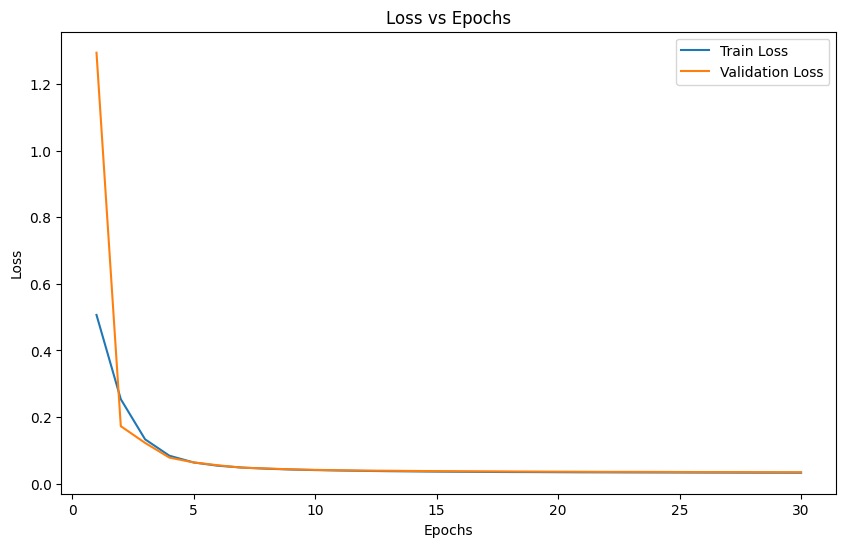

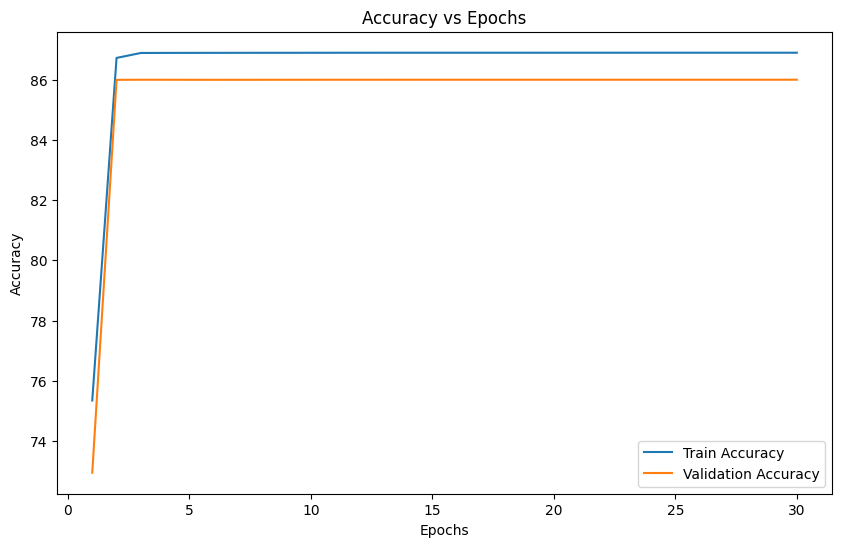

C:\Users\priya\AppData\Local\Temp\ipykernel_35868\4203269746.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(epochs, [torch.tensor(x).item() for x in metrics[metric_keys[0]]], label=f"Train {title}")
C:\Users\priya\AppData\Local\Temp\ipykernel_35868\4203269746.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(epochs, [torch.tensor(x).item() for x in metrics[metric_keys[1]]], label=f"Validation {title}")


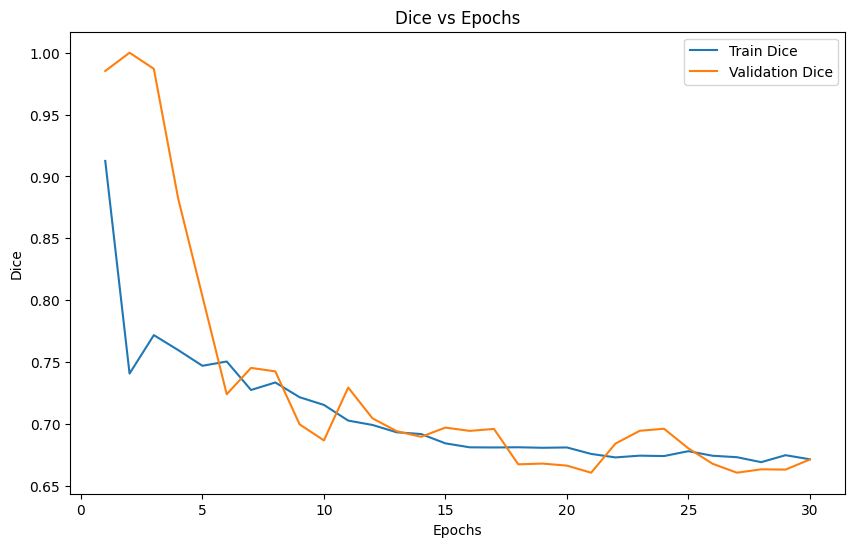

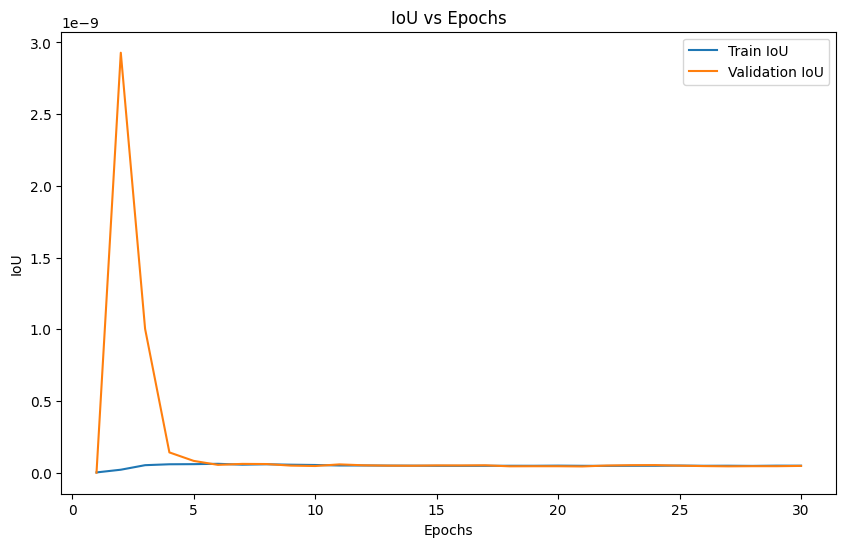

C:\Users\priya\AppData\Local\Temp\ipykernel_35868\2705061681.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # This loads the entire mod

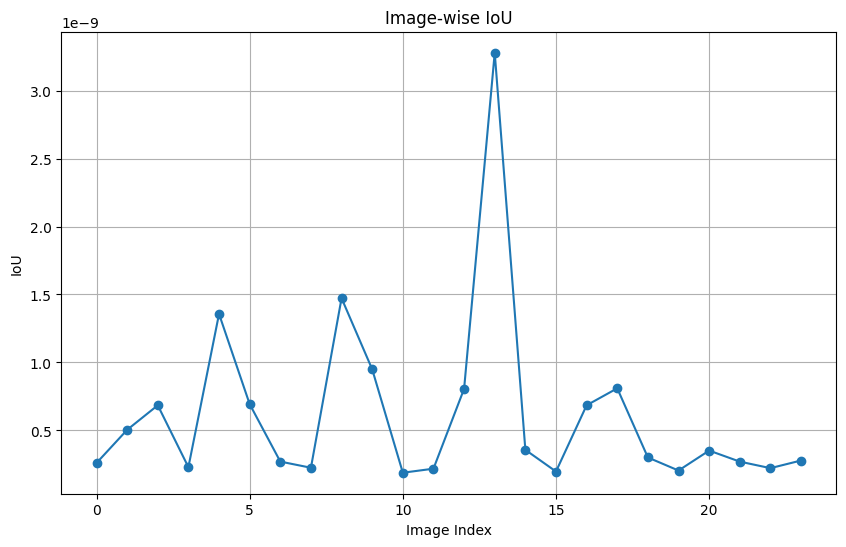

Average IoU on test set: 0.0000
Testing completed. Average IoU: 0.0000
